In [1]:
# This version is without chatGPT summarization just cosine 

In [2]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch



2024-07-01 17:28:14.414106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 17:28:15.265909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Unzipping csv file

In [3]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

In [4]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [5]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set


# Creating isDuplicate column

In [6]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_281617/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


isDuplicate
0    56126
1    11998
Name: count, dtype: int64


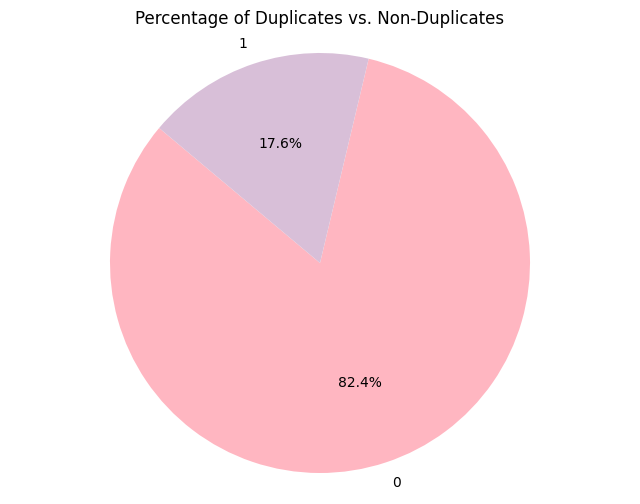

In [85]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'isDuplicate' is the column indicating duplicates
duplicate_counts = df['isDuplicate'].value_counts()

# Check the contents of duplicate_counts
print(duplicate_counts)

# Create a list of labels matching the length of duplicate_counts
# Ensure the labels match the values in the 'isDuplicate' column
labels = duplicate_counts.index.tolist()

# Define colors (length should match number of unique values in 'isDuplicate')
colors = ['#FFB6C1', '#D8BFD8'][:len(labels)]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(duplicate_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Duplicates vs. Non-Duplicates')
plt.axis('equal')
plt.show()


# Preprocessing

In [8]:
df['Description'] = df['Description'].astype(str).fillna('')

/tmp/ipykernel_281617/77102330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'] = df['Description'].astype(str).fillna('')


In [9]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_281617/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_281617/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Creating topics using LDA

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')

# Fit and transform the CountVectorizer on the text data
counts = count_vectorizer.fit_transform(df['full_text_data'])

count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
counts = count_vectorizer.fit_transform(df['full_text_data'])

        # Fit LDA model
lda = LatentDirichletAllocation(n_components=7, max_iter=10,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(counts)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [11]:
feature_names = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-20 - 1:-1]]))
        
        print()

Topic 1:
framework junit dylib tests thread versions frameworks test com library apple testsuite 4xestacktrace libclient uitestapplication testresult testcase carbon 0010 remotetestrunner

Topic 2:
eclipse org core osgi update framework plugins message ui com jar bundle platform help equinox http ibm runtime apache entry

Topic 3:
swt new shell display line string public table int event import eclipse null object void org tree image item return

Topic 4:
lib eclipse 03 00000000 usr dll 00 object jar xp system32 org java windows lang plugins rwxp jre 08 02

Topic 5:
java org eclipse internal ui core swt run widgets main workbench jface display runtime lang method widget reflect launcher invoke

Topic 6:
editor text view open window line click dialog help search page menu select perspective tab does button ctrl editors right

Topic 7:
file project build eclipse new cvs error view workspace files use dialog using does bug problem create user set like



In [12]:
#for alll columns in the df 
#compare each bug report to each topic 
#if
topic_distributions = lda.transform(counts)

In [13]:
df['topic'] = topic_distributions.argmax(axis=1)

# Create DataFrames for each topic
topic_dfs = []
for topic_idx in range(7):
    topic_df = df[df['topic'] == topic_idx].copy()
    topic_dfs.append(topic_df)

# Display the DataFrames for each topic
for i, topic_df in enumerate(topic_dfs):
    print(f"Topic {i}:")
    print(topic_df['full_text_data'])
    print()

# Optionally, you can save each DataFrame to a CSV file
for i, topic_df in enumerate(topic_dfs):
    topic_df.to_csv(f'topic_{i}_bug_reports.csv', index=False)

/tmp/ipykernel_281617/2460893164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


Topic 0:
2735     Eclipse cannot display Japanese letters in the...
2736     Please see the following test result of NLSed ...
3320                                 This is a test PRTest
4775     The following entries in the org.eclipse.jface...
6971     There are no senders of ResourceState:storeSta...
                               ...                        
67512    In recent builds:; ; WIN XP; SUN 1.4.2; ; Wron...
67525    I have a java application that has been workin...
67599    1. Make a view a fast view.; 2. Click on the n...
67826     Simplification in ContentMergeViewer#setRight...
68048    I20080429-0100.; ; CachedMarkerBuilder writes ...
Name: full_text_data, Length: 275, dtype: object

Topic 1:
105      The ingore resources page has the list box far...
221      prefix        test; name          181178; refe...
222      prefix        test; name          181342; refe...
245      I created a new stream in the repository; made...
295      |     To:  Brian Young/OTT/OTI@OTI; Da

In [14]:
topic_0_df=pd.read_csv('topic_0_bug_reports.csv')
topic_1_df=pd.read_csv('topic_1_bug_reports.csv')
topic_2_df=pd.read_csv('topic_2_bug_reports.csv')
topic_3_df=pd.read_csv('topic_3_bug_reports.csv')
topic_4_df=pd.read_csv('topic_4_bug_reports.csv')
topic_5_df=pd.read_csv('topic_5_bug_reports.csv')
topic_6_df=pd.read_csv('topic_6_bug_reports.csv')


#storaging them in seperate csv so when we do classifciaton on them its alll seperate 

In [15]:
df['topic'] = topic_distributions.argmax(axis=1)
#adds column for topic to the df 


/tmp/ipykernel_281617/1678119556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_distributions.argmax(axis=1)


# Comparing the bug text using Cosine Similarity

### I am running this for topic 0 first to see how it works. Then I will refactor so that I can run it for all topics 

In [16]:
pip install sentence-transformers pandas torch


Note: you may need to restart the kernel to use updated packages.


In [17]:
from sentence_transformers import SentenceTransformer, util


/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [18]:
import torch
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode sentences and store the embeddings in the DataFrame
topic_0_df['embeddings'] = topic_0_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))

# Convert embeddings to a tensor
embeddings = torch.stack(topic_0_df['embeddings'].tolist())

# Calculate cosine similarity
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)


print(cosine_scores)


/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


tensor([[1.0000, 0.9213, 0.1975,  ..., 0.4375, 0.0924, 0.1349],
        [0.9213, 1.0000, 0.2574,  ..., 0.4001, 0.0968, 0.1321],
        [0.1975, 0.2574, 1.0000,  ..., 0.0065, 0.1446, 0.1364],
        ...,
        [0.4375, 0.4001, 0.0065,  ..., 1.0000, 0.2337, 0.2753],
        [0.0924, 0.0968, 0.1446,  ..., 0.2337, 1.0000, 0.1709],
        [0.1349, 0.1321, 0.1364,  ..., 0.2753, 0.1709, 1.0000]])


In [19]:
numpy_array = cosine_scores.numpy()

# Reshape the NumPy array into a matrix
similarity_Matrix= numpy_array.reshape(cosine_scores.shape)


similarity_Matrix= np.round(similarity_Matrix, decimals=4)
print(similarity_Matrix)
print(similarity_Matrix.shape)


[[1.     0.9213 0.1975 ... 0.4375 0.0924 0.1349]
 [0.9213 1.     0.2574 ... 0.4001 0.0968 0.1321]
 [0.1975 0.2574 1.     ... 0.0065 0.1446 0.1364]
 ...
 [0.4375 0.4001 0.0065 ... 1.     0.2337 0.2753]
 [0.0924 0.0968 0.1446 ... 0.2337 1.     0.1709]
 [0.1349 0.1321 0.1364 ... 0.2753 0.1709 1.    ]]
(275, 275)


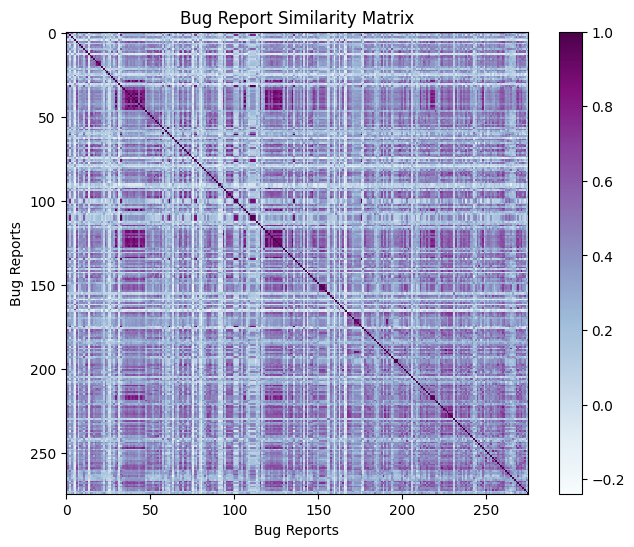

In [20]:


# Assuming your similarity matrix is named 'similarity_matrix'
# Replace this with your actual similarity matrix

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_Matrix, cmap='BuPu', interpolation='nearest')
plt.colorbar()  # Add color bar to show the scale
plt.title('Bug Report Similarity Matrix')
plt.xlabel('Bug Reports')
plt.ylabel('Bug Reports')
plt.show()

# Matching df and matrix?

In [21]:
threshold_value = 0.
#"hyperparmeter" kkinda except this isny machine learning 

In [22]:

# Function to filter rows based on condition
def filter_matrix(matrix, threshold):
    filtered_matrix = []
    for row in matrix:
        if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
            filtered_matrix.append(row)
    return np.array(filtered_matrix)

# Filtering the matrix
filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)

print("\nFiltered Matrix:")
print(filtered_matrix)
print(filtered_matrix.shape)
print(filtered_matrix.shape[0])#number of rows 


Filtered Matrix:
[[1.     0.9213 0.1975 ... 0.4375 0.0924 0.1349]
 [0.9213 1.     0.2574 ... 0.4001 0.0968 0.1321]
 [0.1975 0.2574 1.     ... 0.0065 0.1446 0.1364]
 ...
 [0.4375 0.4001 0.0065 ... 1.     0.2337 0.2753]
 [0.0924 0.0968 0.1446 ... 0.2337 1.     0.1709]
 [0.1349 0.1321 0.1364 ... 0.2753 0.1709 1.    ]]
(275, 275)
275


In [23]:
import numpy as np
import pandas as pd

n = 0
topic_0_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
while n < filtered_matrix.shape[0]:  # number of rows
    matrix = filtered_matrix[n]

    def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
        result = np.where(matrix == 1.0)
        return result[0][0]  # Extract the first index directly

    def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
        condition = np.logical_and(matrix > threshold_value, matrix < 1)
        indices = np.argwhere(condition)
        return indices

    def get_duplicate_ids(matrix_indexs_of_duplicates):
        duplicate_ids = ""
        for row in matrix_indexs_of_duplicates:
            for element in row:
                specific_row = topic_0_df.iloc[element]
                duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
        return duplicate_ids

    index_in_df = find_position(matrix)  # index of selected bug
    specific_row = topic_0_df.iloc[index_in_df]  # selects bug row in dataframe

    duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
    #print(int(index_in_df))
    #print(get_duplicate_ids(duplicateIDs_index_in_df))
    topic_0_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
    
    # print(specific_row['Issue_id'])  # goes into row of selected bug and prints the bug id
    # print(get_duplicate_ids(duplicateIDs_index_in_df))
    #print(topic_0_df['Experimental_Duplicate_ID'][index_in_df])
    #topic_0_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
    n += 1  # to go through each row in the matrix
print(topic_0_df['Experimental_Duplicate_ID'])

/tmp/ipykernel_281617/3371150635.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  topic_0_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
/tmp/ipykernel_281617/3371150635.py:32: SettingWithCopyWar

0       6137 7394 10114 14461 17390 18124 21177 23135...
1       6135 7394 10114 14461 17390 18124 21177 23135...
2       6135 6137 10114 14461 16868 17390 18124 21177...
3       6135 6137 7394 14461 17390 18124 21177 23135 ...
4       6135 6137 7394 10114 16868 17390 18124 21177 ...
                             ...                        
270     6135 6137 7394 10114 14461 17390 18124 21177 ...
271     6135 6137 7394 10114 14461 17390 21177 23135 ...
272     6135 6137 7394 10114 14461 17390 18124 21177 ...
273     6135 6137 7394 10114 14461 16868 17390 18124 ...
274     6135 6137 7394 10114 14461 17390 18124 21177 ...
Name: Experimental_Duplicate_ID, Length: 275, dtype: object


## Results

In [24]:
topic_0_df.fillna(0,inplace=True) #fills with zeros for new column 

In [25]:
topic_0_df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,isDuplicate,full_text_data,topic,embeddings,Experimental_Duplicate_ID
0,6135,P2,UI,0.0,NLS WSDD problems in IDE and VM - Japanese pro...,Eclipse cannot display Japanese letters in the...,CLOSED,FIXED,1.0,2001-11-20 17:49:00 -0500,2005-05-10 14:56:02 -0400,0,Eclipse cannot display Japanese letters in the...,0,"[tensor(-0.1554), tensor(-0.5071), tensor(-0.0...",6137 7394 10114 14461 17390 18124 21177 23135...
1,6137,P2,UI,0.0,NLS WSDD problems in IDE and VM - ASCII project,Please see the following test result of NLSed ...,CLOSED,FIXED,1.0,2001-11-20 17:54:00 -0500,2005-05-10 14:56:28 -0400,0,Please see the following test result of NLSed ...,0,"[tensor(-0.1815), tensor(-0.4352), tensor(-0.1...",6135 7394 10114 14461 17390 18124 21177 23135...
2,7394,P3,UI,0.0,Test,This is a test PR,RESOLVED,INVALID,1.0,2002-01-09 13:47:00 -0500,2002-01-21 21:29:19 -0500,0,This is a test PRTest,0,"[tensor(-0.2421), tensor(0.1078), tensor(-0.14...",6135 6137 10114 14461 16868 17390 18124 21177...
3,10114,P3,Releng,0.0,NL: WSWB rollup 2 - Japanese translations have...,The following entries in the org.eclipse.jface...,CLOSED,FIXED,2.0,2002-02-22 14:45:00 -0500,2002-11-21 14:23:47 -0500,0,The following entries in the org.eclipse.jface...,0,"[tensor(-0.2245), tensor(0.0546), tensor(-0.16...",6135 6137 7394 14461 17390 18124 21177 23135 ...
4,14461,P3,Team,0.0,Dav: No senders of ResourceState:storeState(),There are no senders of ResourceState:storeSta...,RESOLVED,FIXED,2.0,2002-04-23 18:14:00 -0400,2002-05-23 21:21:02 -0400,0,There are no senders of ResourceState:storeSta...,0,"[tensor(-0.1081), tensor(-0.3207), tensor(-0.0...",6135 6137 7394 10114 16868 17390 18124 21177 ...


In [26]:
topic_0_df['Experimental_Duplicate_ID']

0       6137 7394 10114 14461 17390 18124 21177 23135...
1       6135 7394 10114 14461 17390 18124 21177 23135...
2       6135 6137 10114 14461 16868 17390 18124 21177...
3       6135 6137 7394 14461 17390 18124 21177 23135 ...
4       6135 6137 7394 10114 16868 17390 18124 21177 ...
                             ...                        
270     6135 6137 7394 10114 14461 17390 18124 21177 ...
271     6135 6137 7394 10114 14461 17390 21177 23135 ...
272     6135 6137 7394 10114 14461 17390 18124 21177 ...
273     6135 6137 7394 10114 14461 16868 17390 18124 ...
274     6135 6137 7394 10114 14461 17390 18124 21177 ...
Name: Experimental_Duplicate_ID, Length: 275, dtype: object

In [27]:
topic_0_df['Duplicated_issue']

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
         ...   
270    252609.0
271         0.0
272         0.0
273         0.0
274         0.0
Name: Duplicated_issue, Length: 275, dtype: float64

In [28]:
# Split the IDs by spaces and strip whitespace
exp_ids = topic_0_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
dup_ids = topic_0_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])

# Convert all elements to strings to ensure consistent comparison
exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
print(exp_ids)
print(dup_ids)
# Check for any matches for each row
matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))

# Print the matches
print(matches)

# Count the number of matches
num_matches = matches.sum()
print(num_matches)



0      [6137.0, 7394.0, 10114.0, 14461.0, 17390.0, 18...
1      [6135.0, 7394.0, 10114.0, 14461.0, 17390.0, 18...
2      [6135.0, 6137.0, 10114.0, 14461.0, 16868.0, 17...
3      [6135.0, 6137.0, 7394.0, 14461.0, 17390.0, 181...
4      [6135.0, 6137.0, 7394.0, 10114.0, 16868.0, 173...
                             ...                        
270    [6135.0, 6137.0, 7394.0, 10114.0, 14461.0, 173...
271    [6135.0, 6137.0, 7394.0, 10114.0, 14461.0, 173...
272    [6135.0, 6137.0, 7394.0, 10114.0, 14461.0, 173...
273    [6135.0, 6137.0, 7394.0, 10114.0, 14461.0, 168...
274    [6135.0, 6137.0, 7394.0, 10114.0, 14461.0, 173...
Name: Experimental_Duplicate_ID, Length: 275, dtype: object
0           [0.0]
1           [0.0]
2           [0.0]
3           [0.0]
4           [0.0]
          ...    
270    [252609.0]
271         [0.0]
272         [0.0]
273         [0.0]
274         [0.0]
Name: Duplicated_issue, Length: 275, dtype: object
0      False
1      False
2      False
3      False
4      False

In [29]:
accuracy=num_matches/len(topic_0_df)
print("Accuracy: %"+str((accuracy*100))) 


Accuracy: %8.0


In [30]:



# Check for identical values
identical_values = topic_0_df[topic_0_df['Experimental_Duplicate_ID'] == topic_0_df['Duplicated_issue']]

# Check for different values
different_values = topic_0_df[topic_0_df['Experimental_Duplicate_ID'] != topic_0_df['Duplicated_issue']]

# Check for missing values
missing_values_exp = topic_0_df[topic_0_df['Experimental_Duplicate_ID'].isnull()]
missing_values_issue = topic_0_df[topic_0_df['Duplicated_issue'].isnull()]

# Assuming you have true positive (TP) and false positive (FP) counts
TP = len(identical_values)  # True positives (Experimental_Duplicate_ID matches Duplicated_issue)
FP = len(different_values)  # False positives (Experimental_Duplicate_ID does not match Duplicated_issue)

# Calculate precision
precision = TP / (TP + FP)

print("Precision value (percentage):%", str(round((100*precision))))
#again for very small scale 

Precision value (percentage):% 3


In [31]:
# Assuming you have true positive (TP) and false negative (FN) counts
FN = len(missing_values_exp)  # False negatives (Experimental_Duplicate_ID missing but Duplicated_issue present)

# Calculate recall
recall = TP / (TP + FN)

print("Recall value:", recall)


Recall value: 1.0


In [32]:
# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1 score:", (f1_score))


F1 score: 0.06338028169014084


# Refactoring

### Creating functions to test with different parameters

In [33]:
def getDuplicateBugIDS(threshold_value,topic_x_df): 
    import torch
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    # Encode sentences and store the embeddings in the DataFrame
    topic_x_df['embeddings'] = topic_x_df['full_text_data'].apply(lambda x: model.encode(x, convert_to_tensor=True))
    # Convert embeddings to a tensor
    embeddings = torch.stack(topic_x_df['embeddings'].tolist())
    # Calculate cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    numpy_array = cosine_scores.numpy()
    # Reshape the NumPy array into a matrix
    similarity_Matrix= numpy_array.reshape(cosine_scores.shape)
    similarity_Matrix= np.round(similarity_Matrix, decimals=4)
    # Function to filter rows based on condition
    def filter_matrix(matrix, threshold):
        filtered_matrix = []
        for row in matrix:
            if np.any((row > threshold) & (row < 1)): #<1 to igorne the sim. with itself 
                filtered_matrix.append(row)
        return np.array(filtered_matrix)
    # Filtering the matrix
    filtered_matrix = filter_matrix(similarity_Matrix, threshold_value)
    n = 0
    topic_x_df['Experimental_Duplicate_ID'] = np.nan  #intailly sets everything to null
    while n < filtered_matrix.shape[0]:  # number of rows do this process to each row 
        matrix = filtered_matrix[n]
        def find_position(matrix):  # finds position (index) of bug all other bugs are comparing to
            result = np.where(matrix == 1.0)
            return result[0][0]  # Extract the first index directly
    
        def get_duplicate_ids_index(matrix):  # finds index where there are most similar bugs to the bug at find_position
            condition = np.logical_and(matrix > threshold_value, matrix < 1)
            indices = np.argwhere(condition)
            return indices
        def get_duplicate_ids(matrix_indexs_of_duplicates):
            duplicate_ids = ""
            for row in matrix_indexs_of_duplicates:
                for element in row:
                    specific_row = topic_x_df.iloc[element]
                    duplicate_ids = duplicate_ids + " " + str(specific_row['Issue_id'])
            return duplicate_ids
        index_in_df = find_position(matrix)  # index of selected bug
        specific_row = topic_x_df.iloc[index_in_df]  # selects bug row in dataframe
        duplicateIDs_index_in_df = get_duplicate_ids_index(matrix)  # index of duplicate bugs
        topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
        n += 1  # to go through each row in the matrix
    return topic_x_df['Experimental_Duplicate_ID']

In [34]:
def accuracy(topic_x_df):
       # Split the IDs by spaces and strip whitespace
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column 
    exp_ids = topic_x_df['Experimental_Duplicate_ID'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    dup_ids = topic_x_df['Duplicated_issue'].astype(str).str.split().apply(lambda x: [i.strip() for i in x])
    
    # Convert all elements to strings to ensure consistent comparison
    exp_ids = exp_ids.apply(lambda x: [float(i) for i in x])
    dup_ids = dup_ids.apply(lambda x: [float(i) for i in x])
    # Check for any matches for each row
    matches = exp_ids.combine(dup_ids, lambda exp_list, dup_list: any(dup_id in exp_list for dup_id in dup_list))
    
    # Count the number of matches
    num_matches = matches.sum()
    accuracy=num_matches/len(topic_x_df)
    return accuracy

In [35]:
def precison(topic_x_df):
    topic_x_df.fillna(0,inplace=True) #fills with zeros for new column
    from sklearn.metrics import precision_score

    actual_values = float(topic_x_df['Duplicated_issue'])
    predicted_values = float(topic_x_df['Experimental_Duplicate_ID'])
    precision = precision_score(actual_values, predicted_values)
    return precision
    #needs fixing

In [36]:
def recall(topic_x_df):
    from sklearn.metrics import recall_score
    
    # Assuming df is your dataframe
    
    actual_values = float(topic_x_df['Duplicated_issue'])
    predicted_values = float(topic_x_df['Experimental_Duplicate_ID'])
    # Calculate recall for Experimental_Duplicate_ID column
    recall= recall_score(actual_values, predicted_values)
    return  recall
    #needs fixing

In [37]:
def f1(topic_x_df):
    from sklearn.metrics import f1_score
    actual_values = float(topic_x_df['Duplicated_issue'])
    predicted_values = float(topic_x_df['Experimental_Duplicate_ID'])
    f1 = f1_score(actual_values, predicted_values)
    return f1
    #needs fixing

In [38]:
def experimentalisDuplicate(topic_x_df): #creates column for binary isDuplciates
    def is_duplicate(val):
        return 1 if val !=(0.0 or 0) else 0
    topic_x_df['isExperimentalDuplicate'] = topic_x_df['Experimental_Duplicate_ID'].apply(lambda x: is_duplicate(x))
    return topic_x_df['isExperimentalDuplicate']

In [39]:
def binaryAccuracy(topic_x_df): #see if the ones and zeros match, different from other acuracy becuase that one can have only one element mathc and it count ex bug 1 has ids 1234 and 8472 it should still count as a duplciate to bug 2 with 1234 0889 
    matches=topic_x_df['isExperimentalDuplicate']==topic_x_df['isDuplicate']
    num_matches=matches.sum()
    accuracy=num_matches/len(topic_x_df['isExperimentalDuplicate'])
    return accuracy

# Testing on topics

In [40]:
accuracyList=[] #this accuracy for matching at least one id in the duplicateID section
binaryAccuracyList=[] #this is the accuracy of if it is a duplciate or not 

In [41]:
topic_0_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_0_df)
accuracyVal=accuracy(topic_0_df)*100
#must be with Val or else theres a naming error 
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)


experimentalisDuplicate(topic_0_df)
binaryAccuracyVal=binaryAccuracy(topic_0_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy for matching id is %69.0909090909091
Accuracy for duplicate or not is %70.18181818181817


/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
/tmp/ipykernel_281617/2579120456.py:45: SettingWithCopyWar

In [42]:
topic_1_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_1_df)
accuracyVal=accuracy(topic_1_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)


experimentalisDuplicate(topic_1_df)
binaryAccuracyVal=binaryAccuracy(topic_1_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy for matching id is %74.44735856125891
Accuracy for duplicate or not is %76.50805545147995


/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
/tmp/ipykernel_281617/2579120456.py:45: SettingWithCopyWar

In [43]:
topic_2_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_2_df)
accuracyVal=accuracy(topic_2_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)

experimentalisDuplicate(topic_2_df)
binaryAccuracyVal=binaryAccuracy(topic_2_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy for matching id is %83.9788089148703
Accuracy for duplicate or not is %84.38070880526124


/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
/tmp/ipykernel_281617/2579120456.py:45: SettingWithCopyWar

In [44]:
topic_3_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_3_df)
accuracyVal=accuracy(topic_3_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)


experimentalisDuplicate(topic_3_df)
binaryAccuracyVal=binaryAccuracy(topic_3_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy for matching id is %54.78142076502732
Accuracy for duplicate or not is %64.20765027322405


/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  topic_x_df['Experimental_Duplicate_ID'][index_in_df]=get_duplicate_ids(duplicateIDs_index_in_df)
/tmp/ipykernel_281617/2579120456.py:45: SettingWithCopyWar

In [45]:
topic_4_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_4_df)
accuracyVal=accuracy(topic_4_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)


experimentalisDuplicate(topic_4_df)
binaryAccuracyVal=binaryAccuracy(topic_4_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

Accuracy for matching id is %52.54726511762159
Accuracy for duplicate or not is %61.466301053543084


In [46]:
topic_5_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_5_df)
accuracyVal=accuracy(topic_5_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)


experimentalisDuplicate(topic_5_df)
binaryAccuracyVal=binaryAccuracy(topic_5_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

Accuracy for matching id is %79.31759179132155
Accuracy for duplicate or not is %79.57720360984052


In [47]:
topic_6_df['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,topic_6_df)
accuracyVal=accuracy(topic_6_df)*100
print("Accuracy for matching id is %" + str(accuracyVal))
accuracyList.append(accuracyVal)

experimentalisDuplicate(topic_6_df)
binaryAccuracyVal=binaryAccuracy(topic_6_df)*100
print("Accuracy for duplicate or not is %" + str(binaryAccuracyVal))
binaryAccuracyList.append(binaryAccuracyVal)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

Accuracy for matching id is %82.75016031449522
Accuracy for duplicate or not is %82.98157080324532


# Whole dataframe no topics

In [48]:
df_test=df.copy()

In [74]:
df_test['Experimental_Duplicate_ID']=getDuplicateBugIDS(.85,df_test)
whole_df_accuracy=accuracy(df_test)*100
experimentalisDuplicate(df_test)
whole_df_binary_accuracy=binaryAccuracy(df_test)*100

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_281617/2579120456.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

# Average accuracy 

In [51]:
import statistics
print(accuracyList)
accuracyListAverage=statistics.mean(accuracyList)
print(binaryAccuracyList)
binaryAccuracyListAverage=statistics.mean(binaryAccuracyList)
print(accuracyListAverage)
print(binaryAccuracyListAverage)

[69.0909090909091, 74.44735856125891, 83.9788089148703, 54.78142076502732, 52.54726511762159, 79.31759179132155, 82.75016031449522]
[70.18181818181817, 76.50805545147995, 84.38070880526124, 64.20765027322405, 61.466301053543084, 79.57720360984052, 82.98157080324532]
70.98764493650057
74.18618688263034


# Graphing results 

In [67]:
print(accuracyList)
print(binaryAccuracyList)

[69.0909090909091, 74.44735856125891, 83.9788089148703, 54.78142076502732, 52.54726511762159, 79.31759179132155, 82.75016031449522]
[70.18181818181817, 76.50805545147995, 84.38070880526124, 64.20765027322405, 61.466301053543084, 79.57720360984052, 82.98157080324532]


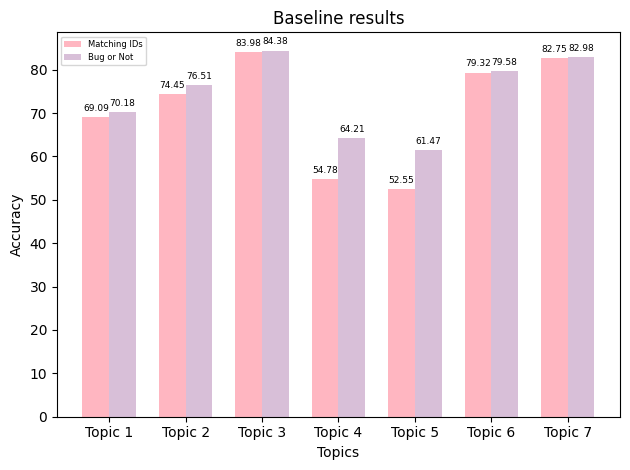

In [70]:
# Sample data
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars_bug = ax.bar(x - width/2, accuracyList, width, label='Matching IDs', color='#FFB6C1')
bars_bug_id = ax.bar(x + width/2, binaryAccuracyList, width, label='Bug or Not', color='#D8BFD8')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Accuracy')
ax.set_title('Baseline results')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

# Adding accuracy labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6.5)
add_labels(bars_bug)
add_labels(bars_bug_id)

ax.legend(loc='upper left', fontsize='small', prop={'size': 6})

plt.tight_layout()
plt.show()


In [76]:
accuracyList.append(whole_df_accuracy)
binaryAccuracyList.append(whole_df_binary_accuracy)

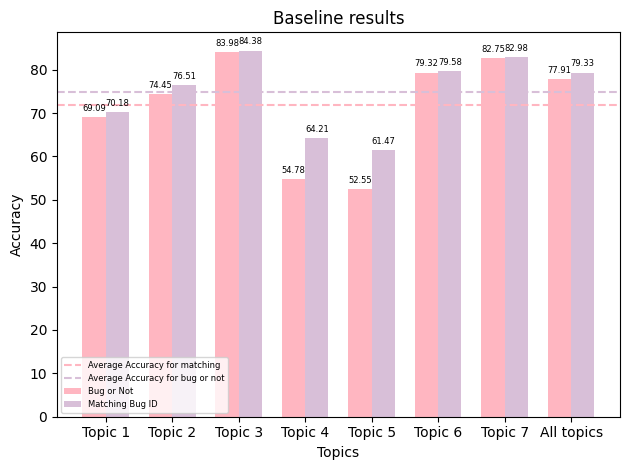

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7','All topics']

x = np.arange(len(topics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars_bug = ax.bar(x - width/2, accuracyList, width, label='Bug or Not', color='#FFB6C1')
bars_bug_id = ax.bar(x + width/2, binaryAccuracyList, width, label='Matching Bug ID', color='#D8BFD8')

# Calculate average values
accuracyListAverage = np.mean(accuracyList)
binaryAccuracyListAverage = np.mean(binaryAccuracyList)

# Plot average lines
ax.axhline(y=accuracyListAverage, color='#FFB6C1', linestyle='--', label='Average Accuracy for matching')
ax.axhline(y=binaryAccuracyListAverage, color='#D8BFD8', linestyle='--', label='Average Accuracy for bug or not')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Topics')
ax.set_ylabel('Accuracy')
ax.set_title('Baseline results')
ax.set_xticks(x)
ax.set_xticklabels(topics)

# Adding accuracy labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=6)  # Adjust font size here

add_labels(bars_bug)
add_labels(bars_bug_id)

# Make the legend smaller
ax.legend(loc='lower left', fontsize='small', prop={'size': 6})

plt.tight_layout()
plt.show()
